# NCorr-FP: POC & analysis

Neighbourhood-based fingerprinting for correlated data is a method of embedding a traceable mark into the tabular data and is unlike its predecessors data driven, meaning that it preserves the existing stats of the data.

This notebook represents the proof-of-concept and preliminary analysis of the method, its effectiveness, fidelity, robustness and effects on data utility. 

## Table of Contents
- [Introduction](#Intro)
- [1. Effectiveness](#1.-Effectiveness)
    - [1.1 Vote errors](1.1-Vote-errors)
- [Data Loading](#Data-Loading)
- [Data Analysis](#Data-Analysis)
- [Results](#Results)
- [Conclusion](#Conclusion)


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
import sys

In [20]:
from NCorr_FP_plot import *

In [21]:
sys.path.insert(0, '../../../dissertation')  # make the script standalone for running on server

In [22]:
from NCorrFP.NCorrFP import NCorrFP, sample_from_area
from datasets import Dataset, Adult

## Introduction 

Below we show a demo snipped of the algorithmic steps of the embedding and detection algorithms for Adult Census data.

In [25]:
data = Adult()
dataset = data.dataframe

In [26]:
scheme = NCorrFP(gamma=16, fingerprint_bit_length=128, k=300)
fingerprinted_data, fingerprint, iter_log = scheme.demo_insertion(data, primary_key_name='Id', secret_key=101, recipient_id=4)

Start the demo NCorr fingerprint insertion algorithm...
	gamma: 16
	correlated attributes: None

Generated a hash fingerprint for recipient 4: 10101101100111010000010001010001101101110011101000011000011001101110111011111000010001000100000011100011000001110011110000000100
Inserting the fingerprint...

Training balltrees in: 2.1459 sec.
Fingerprint inserted.
Runtime: 41.0 sec.


Marking record no. 12
Marking attribute: race
The record to mark: 
   Id  age  workclass  fnlwgt  education  education-num  marital-status  \
0   0   39          7   77516          9             13               4   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           1             1     4    1          2174             0   

   hours-per-week  native-country  income  
0              40              39       0  
------------------------------------------------------------------------------------------------------------------
How to mark the new value:
Based on PRNG from this iteration, we use fingerprint bit at index 42, i.e. bit 1 and xor it with the mask bit (also from PRNG), in this case 0.
This operation gives us the MARK BIT. Mark bit determines how we sample the new value.

First, we look at the values of attribute race in this neighbourhood, and among these is our potential new value.
For this we estimate the distribution of these target values (se

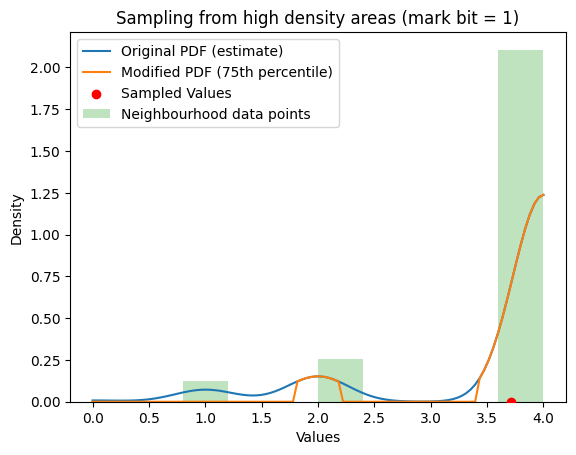

The sampled continuous value is rounded to the closest existing value from the data (to avoid perceptibility of marks) and is: 4
The fingerprinted record is:
   Id  age  workclass  fnlwgt  education  education-num marital-status  \
0   0   39  State-gov   77516  Bachelors             13  Never-married   

     occupation   relationship   race   sex  capital-gain  capital-loss  \
0  Adm-clerical  Not-in-family  White  Male          2174             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  


In [27]:
show_embedding_iteration(0, fingerprinted_data, iter_log, dataset)

In [8]:
suspect, det_fingerprint, det_iter_log = scheme.demo_detection(fingerprinted_data, secret_key=101, primary_key='Id',
                               original_columns=list(dataset.drop('Id', axis=1).columns))

Start demo NCorr fingerprint detection algorithm ...
	gamma: 16
	correlated attributes: None
Training balltrees in: 1.3499 sec.
Fingerprint detected: 10101101100111010000010001010001101101110011101000011000011001101110111011111000010001000100000011100011000001110011110000000100
Runtime: 31.95 sec.


## 1. Effectiveness

The first requirements of the fingerprinting method is its effectiveness. 
To that end, we measure:
1. Detection error rates (rate of wrong votes)
2. Detection rate (number of bits correctly extracted)

This depends on the numbed of marked records and neighbourhood size.

In [30]:
results_effectiveness = pd.read_csv('effectiveness_adult.csv')
results_effectiveness.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,vote_error,tp,tn
0,2,300,128,20,100,0,tardos,0.5,0.012737,1.0,0.812500
1,2,300,128,20,100,0,tardos,0.5,0.012737,1.0,0.796875


### 1.1 Vote errors
To recap from the demo, some detection errors are made due to slight shift in data distributions in fingerprinted dataset (depicted in color red in tables from the demo of the detection algorithm).

We here experimentaly quantify these errors depending on neighbourhood size and number of embedded marks.

Hypohteses:
- small neighbourhood size causes more detection errors bacuse the distributions might not be representative; too big neighbourhood might have some computational cost and not presrve the correlations as well
- the more marks embedded, the more errors introduced

In [31]:
# vote errors on forest cover data

# x-axis: gamma
# y-axis: vote error rate
# colors: neighbourhood size
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: fp_length (128), n_recipients (20), recipient_id (0) , code (tardos)

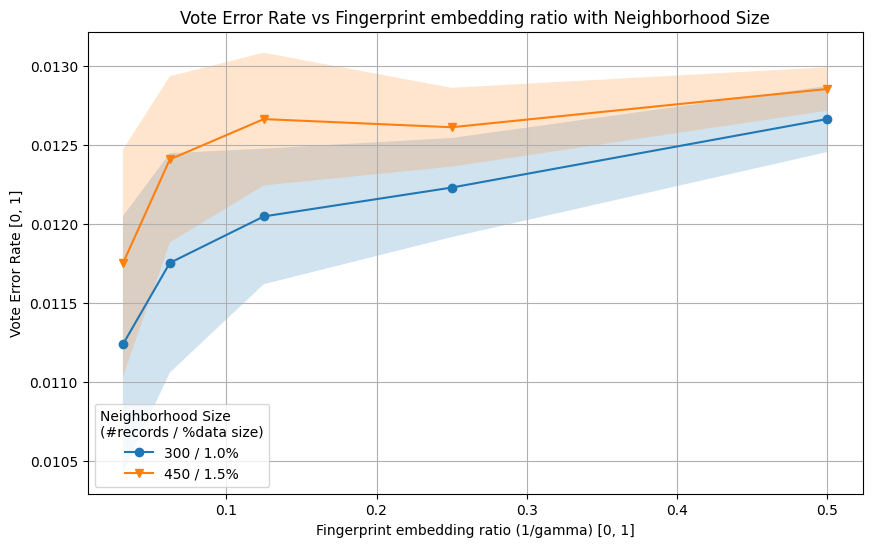

In [32]:
# fixed: fp_length (128), n_recipients (20), recipient_id (0) 
results_effectiveness_ver = results_effectiveness[results_effectiveness["fingerprint_length"]==128]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["n_recipients"]==20]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["id"]==0]
results_effectiveness_ver = results_effectiveness_ver[results_effectiveness_ver["code"]=='tardos']

# Generate the plot
plot_vote_error_rate(results_effectiveness_ver)

The vote error of around 1.3% in combination with a small standard deviation gives a good confidence that the fingerprint bits are going to be extracted with 100% accuracy.  

### 2. Fingerprint bit errors (Correct fingerprint confidence)

This measure depicts more closely the actual extraction success for the fingerprint. Normally, we would want a 100% extraction ratio, i.e. all bits are correctly extracted, however, a high percentage associated to a fingerprint of one recipient might be indicator enough for the correct recipient, especially if the rate is low for other recipients (i.e. around 50% for random guessing).
The extraction provides a probability vector for each recipient; we measure the probability for the correct fingerprint. In the next point, we look at extraction rate for true negatives.

Hypotheses:
- Fingerprint bit length and number of marks embedded in combination affect the detection success rate. Fingerprints that are long, but embeddedd with a low number of marks may have a low extraction success because some bits might not be embedded at all (they are chosen randomly). 

Experiment:
- 10 fingerprint embeddings
- 10 different gammas (fp embedding ratios)
- 3 different fingerprint lengths

In [12]:
# fingerprint bit errors (correct fingerprint confidence)

# x-axis: gamma
# y-axis: correct fingerprint confidence
# color: fingerprint lenght
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: k (300), n_recipients (20), recipient_id (0) 

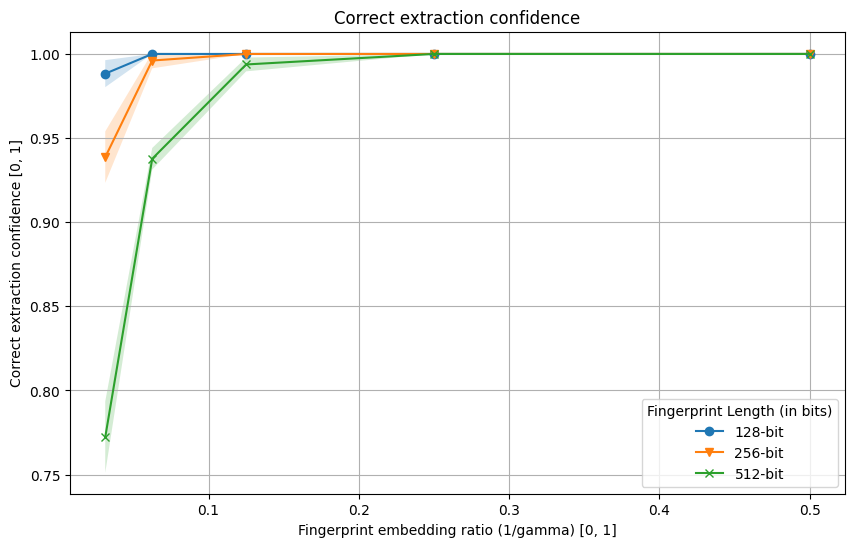

In [33]:
# fixed: k (300), n_recipients (20), recipient_id (0) , code (tardos)
results_effectiveness_tp = results_effectiveness[results_effectiveness["k"]==300]
results_effectiveness_tp = results_effectiveness_tp[results_effectiveness_tp["n_recipients"]==20]
results_effectiveness_tp = results_effectiveness_tp[results_effectiveness_tp["id"]==0]
results_effectiveness_tp = results_effectiveness_tp[results_effectiveness_tp["code"]=='tardos']

plot_tp_confidence(results_effectiveness_tp)

Referring to the hypothesis: the extraction confidence indeed drops lower for longer fingerprints at low embedding ratios. 

### 3. True negatives

Here we look at how the probabilities look like for wrong recipients. In every fingerprint detection, the algorithm outputs confidences for all recipients. In ideal scenario, the confidence of the correct recipient is 1.0 (i.e. perfect bit-wise matching of a detected fingerprint to the fingerprint of the correct recipient), and the confidences of all other recipients are around 0.5, in line with random guessing of the bit-sequence.

Experiment (same as above):
- fixed: 10 recipients
- 20 fingerprint embeddings
- 10 different gammas
- 3 different fingerprint lengths

In [14]:
# true negatives confidence

# x-axis: gamma 
# y-axis: false fingerprint confidence (this is the confidence that gets assigned to the wrong recipient)
# z-axis: tardos, hash
# color: fingerprint lenght
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: k (300), n_recipients (20), recipient_id (0) 

In [34]:
results_effectiveness_tn = results_effectiveness[results_effectiveness["k"]==300]
results_effectiveness_tn = results_effectiveness_tn[results_effectiveness_tn["n_recipients"]==20]
results_effectiveness_tn = results_effectiveness_tn[results_effectiveness_tn["id"]==0]

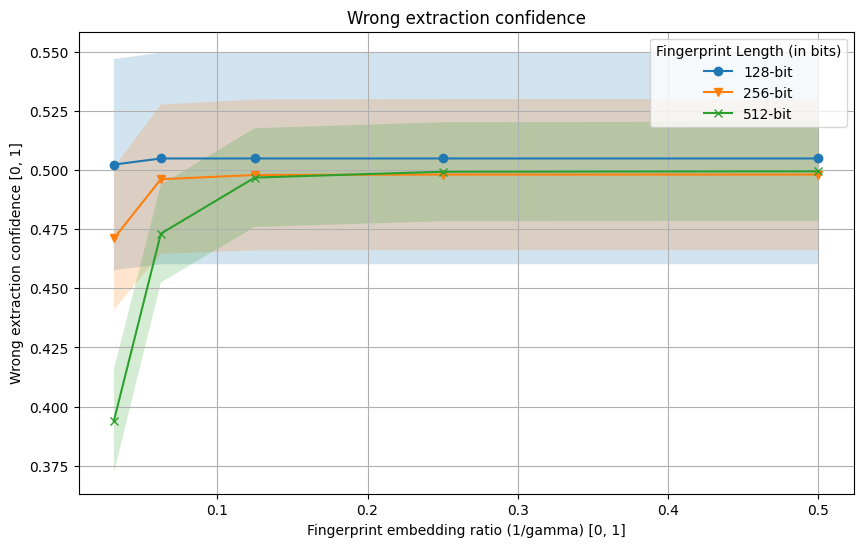

In [35]:
plot_tn_confidence(results_effectiveness_tn[results_effectiveness_tn['code']=='hash'])

Naturally, the standard deviation for the confidences of shorter fingerprints are larger, however the overall average is around 50% in line with the hypothesis. It means that the wrong recipient will match the extracted fingerprint with around 50% bits which is equivalent to random guessing and insignificant for accusation. 



**Tardos codes** are constructed differently, where fingerprints by design have a certain overlap. Unlike a hash fingerprint where each bit has independednt probability of selection 50/50, tardos codes share common bit-wise probabilities. The confidences in wrong fingerprints (by exact matching) are therefore somewhat higher for Tardos:

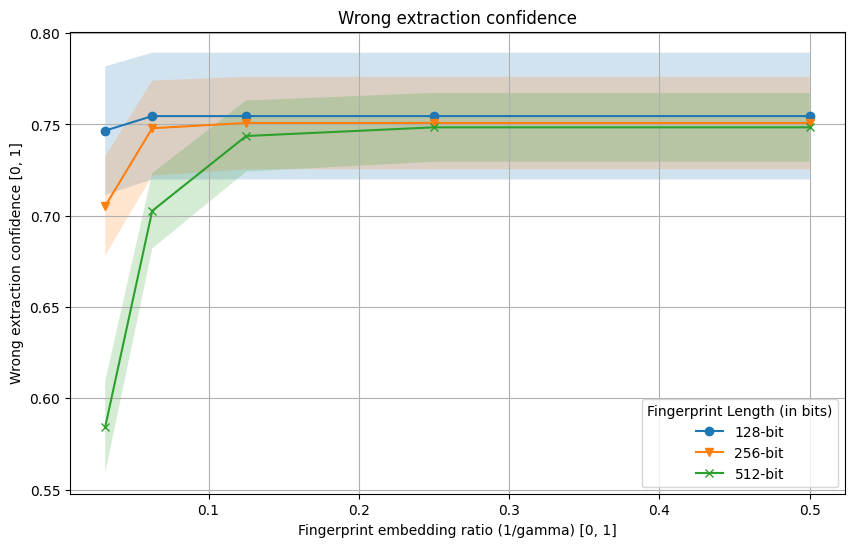

In [36]:
plot_tn_confidence(results_effectiveness_tn[results_effectiveness_tn['code']=='tardos'])

**Summary:** For clearer view we merge true positive confidences, and true negative (seeing distinctive difference between hash and tardos codes):

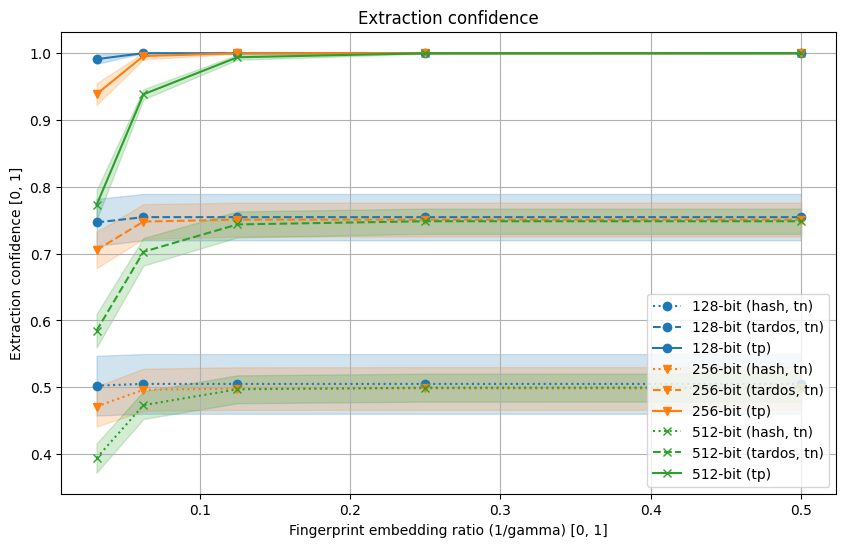

In [37]:
plot_tp_tn_confidence(results_effectiveness_tn)

## 2. Fidelity 

The second requirement is fidelity, i.e. how preserved the data is. 

0. Accuracy (number of preserved values)
1. Univariate statistics
2. Bi-variate stats

We take two angles: 
- Fidelity overall, to measure how the scheme preserves the data quality overall by changing the seed for the experiments (owner's secret key). 
- Stability of the fidelity: How mutually different the datasets are between different recipients? For this we compare the datasets originating from the same secret key -- this simulates the instance of the fingerprint usage, where the owner embedds their fingerprint and distributes the datasets.

In [47]:
results_fidelity = pd.read_csv('fidelity_univariate_adult.csv')
results_fidelity.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,attribute,rel_delta_mean,rel_delta_std,hellinger_distance,kl_divergence,emd,ks,p_value
0,2,300,128,20,100,0,tardos,0.5,0,age,0.000543,0.001205,0.001986,0.000016,0.040877,0.001935,1.000000
1,2,300,128,20,100,0,tardos,0.5,0,fnlwgt,0.000187,0.000756,0.005599,0.000114,514.149719,0.002518,0.999945


In [48]:
results_fidelity_bivar = pd.read_csv('fidelity_bivariate_adult.csv')
results_fidelity_bivar.head(2)

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,accuracy,marital-status-relationship,marital-status-sex,relationship-sex,income-relationship,education-education-num,age-marital-status,education-num-occupation,age-relationship
0,2,300,128,20,100,0,tardos,0.5,0,0.018812,0.019918,0.003347,0.018347,0.059507,0.001086,0.053191,0.010132,0.087056
1,2,300,128,20,100,1,tardos,0.5,1,0.018834,0.019463,0.002507,0.017718,0.057474,0.001209,0.053238,0.009727,0.086239


### 2.1 Univariate - dataset accuracy, delta mean & std

In [43]:
# dataset accuracy 

# x-axis: gamma 
# y-axis: accuracy (1 - % changed values)  - expected: <= embedding_ratio/n_columns
# color: k (neighbourhood size)
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fixed: n_recipients (20), recipient_id (0), fp_length (128) , code (tardos)

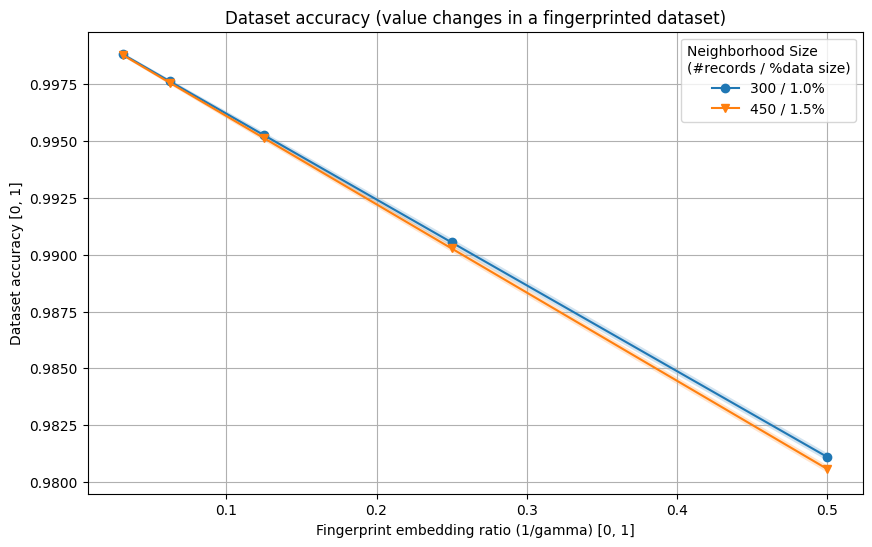

In [49]:
# fixed: n_recipients (20), recipient_id (0), fp_length (128) 
results_fidelity_bivar_acc = results_fidelity_bivar[results_fidelity_bivar['n_recipients']==20]
results_fidelity_bivar_acc = results_fidelity_bivar_acc[results_fidelity_bivar_acc['recipient_id']==0]
results_fidelity_bivar_acc = results_fidelity_bivar_acc[results_fidelity_bivar_acc['fingerprint_length']==128]
results_fidelity_bivar_acc = results_fidelity_bivar_acc[results_fidelity_bivar_acc['code']=='tardos']

plot_data_accuracy(results_fidelity_bivar_acc)

We can observe the expected linear behaviour of dataset accuracy depending on fingerprint embedding ratio. 
The neighbourhood size does not seem to affect the accuracy.

In [154]:
results_fidelity_bivar_acc

,gamma,k,fingerprint_length,n_recipients,sk,id,code,embedding_ratio,recipient_id,accuracy,marital-status-relationship,marital-status-sex,relationship-sex,income-relationship,education-education-num,age-marital-status,education-num-occupation,age-relationship
0,2,300,128,20,100,0,tardos,0.50000,0,0.018812,0.019918,0.003347,0.018347,0.059507,0.001086,0.053191,0.010132,0.087056
20,2,300,128,20,101,0,tardos,0.50000,0,0.018734,0.019437,0.005494,0.016930,0.051300,0.000952,0.057474,0.007876,0.074466
21,2,300,128,20,102,0,tardos,0.50000,0,0.018828,0.022074,0.002237,0.020420,0.061259,0.002038,0.042118,0.008260,0.080203
22,2,300,128,20,103,0,tardos,0.50000,0,0.019225,0.017935,0.006351,0.015445,0.061925,0.001992,0.055598,0.010479,0.078464
23,2,300,128,20,104,0,tardos,0.50000,0,0.018961,0.021369,0.004215,0.018160,0.056212,0.001929,0.059105,0.000633,0.066790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,32,450,128,20,105,0,tardos,0.03125,0,0.001214,0.001842,0.000888,0.001571,0.003322,0.000245,0.001340,0.001221,0.003968
371,32,450,128,20,106,0,tardos,0.03125,0,0.001228,0.001631,0.001825,0.001478,0.003803,0.000069,0.006936,0.000210,0.005841
372,32,450,128,20,107,0,tardos,0.03125,0,0.001126,0.001586,0.000640,0.001358,0.002498,0.000880,0.004716,0.003189,0.006279
373,32,450,128,20,108,0,tardos,0.03125,0,0.001145,0.001816,0.001892,0.001454,0.003830,0.000167,0.003564,0.001074,0.005034


In [155]:
results_fidelity_bivar_acc.groupby(['gamma'])['accuracy'].aggregate(['mean', 'std']).reset_index()

,gamma,mean,std
0,2,0.019168,0.000315
1,4,0.009592,0.000206
2,8,0.004800,0.000141
3,16,0.002403,0.000087
4,32,0.001199,0.000070


In [ ]:
# accuracy from random fingerprinting

In [45]:
# Relative delta mean per attribute (i.e. normalised by the attribute's values range)

# x-axis: gamma 
# y-axis: relative delta mean value
# color: data attributes (only numerical)
# avg and std over differen secret keys (i.e. seeds for randomised experiments)
# fix: k (300), n_recipients (20), recipient_id (0), fp_length (128) 

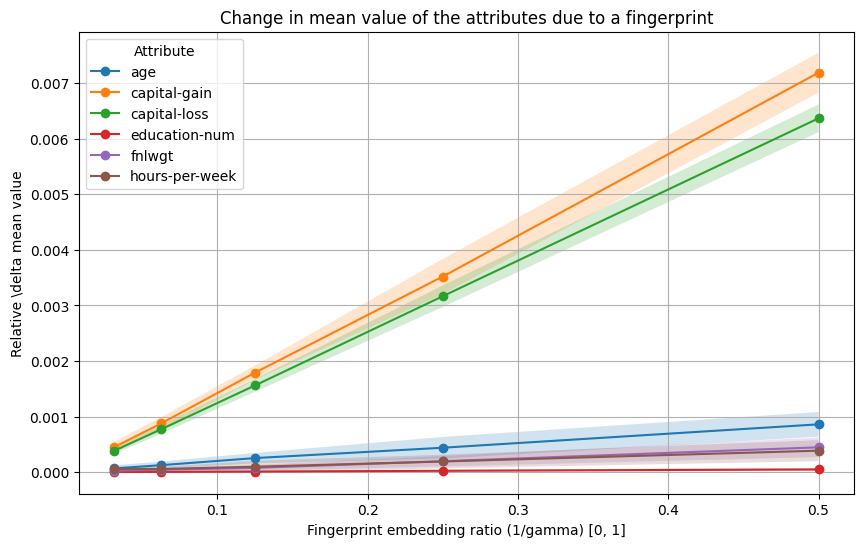

In [50]:
# showinng diff in mean and std only for numerical attributes
results_fidelity_num = results_fidelity[~results_fidelity["attribute"].isin(["Id", "income"])]
# fix: k (300), n_recipients (20), recipient_id (0), fp_length (128) 
results_fidelity_num = results_fidelity_num[results_fidelity_num["k"]==300]
results_fidelity_num = results_fidelity_num[results_fidelity_num["recipient_id"]==0]
results_fidelity_num = results_fidelity_num[results_fidelity_num["n_recipients"]==20]
results_fidelity_num = results_fidelity_num[results_fidelity_num["fingerprint_length"]==128]

plot_delta_mean(results_fidelity_num)

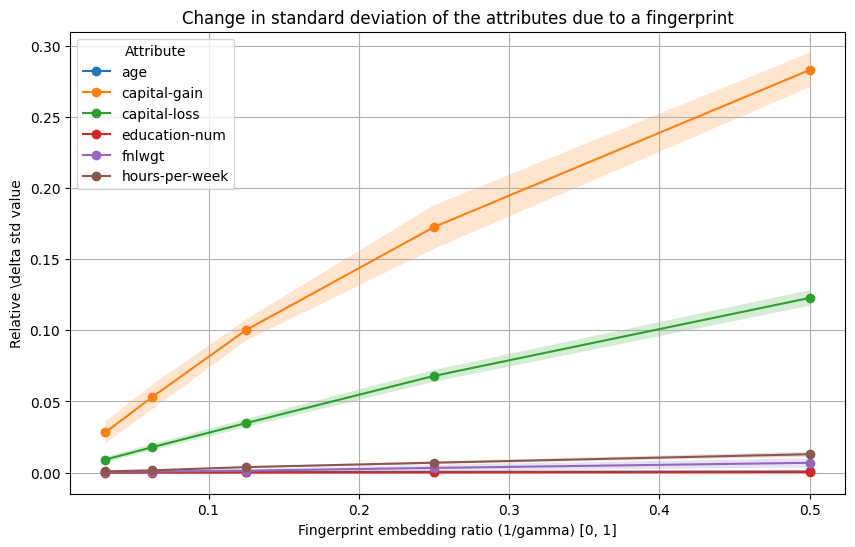

In [55]:
plot_delta_std(results_fidelity_num)

**Stability** - how similar are the datasets distributed to different recipieents?

In [51]:
# insert delta mean per attribute

# x-axis: gamma 
# y-axis: relative delta mean value
# color: data attributes (only numerical)
# STABILITY: avg and std over different recipients (how similar the distributed datasets are; ideally shading is small)
# fix: k (300), n_recipients (20), sk (100), fp_length (128) , code (tardos)

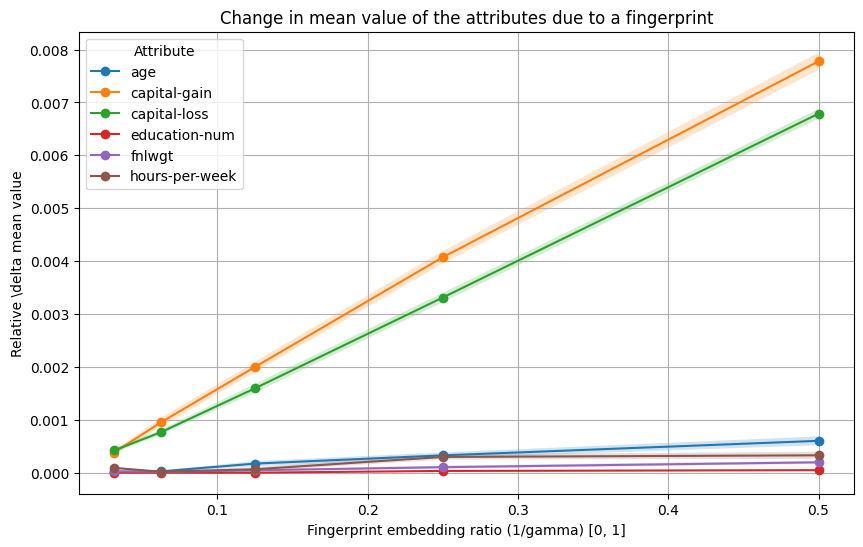

In [54]:
# showinng diff in mean and std only for numerical attributes
results_fidelity_num_stability = results_fidelity[~results_fidelity["attribute"].isin(["Id", "income"])]
# fix: k (300), n_recipients (20), recipient_id (0), fp_length (128) 
results_fidelity_num_stability = results_fidelity_num_stability[results_fidelity_num_stability["k"]==300]
results_fidelity_num_stability = results_fidelity_num_stability[results_fidelity_num_stability["sk"]==100]
results_fidelity_num_stability = results_fidelity_num_stability[results_fidelity_num_stability["n_recipients"]==20]
results_fidelity_num_stability = results_fidelity_num_stability[results_fidelity_num_stability["fingerprint_length"]==128]
results_fidelity_num_stability = results_fidelity_num_stability[results_fidelity_num_stability["code"]=='tardos']

plot_delta_mean(results_fidelity_num_stability)

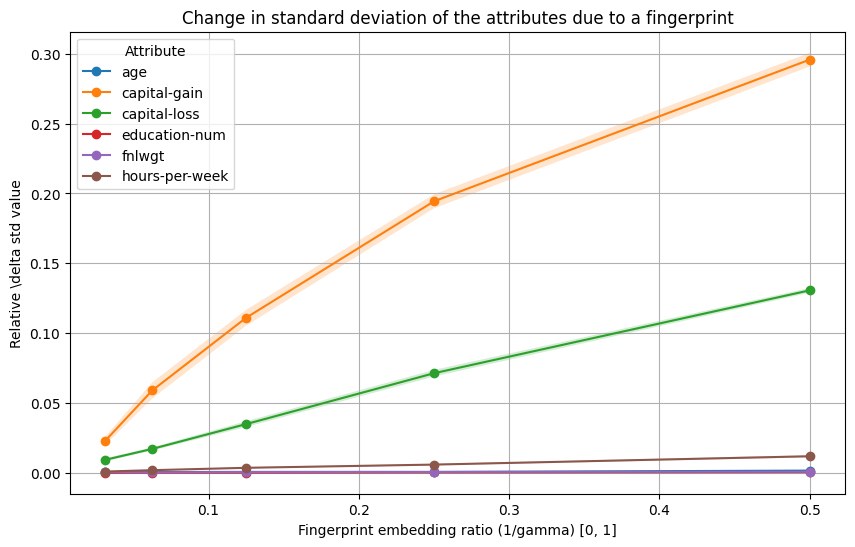

In [56]:
plot_delta_std(results_fidelity_num_stability)

In [57]:
# insert histograms

# x-axis: gamma 
# y-axis: attribute
# color: original baseline + disrtibution of the attribute
# fix: k (300), n_recipients (20), sk (100), fp_length (64) recipient_id (0)

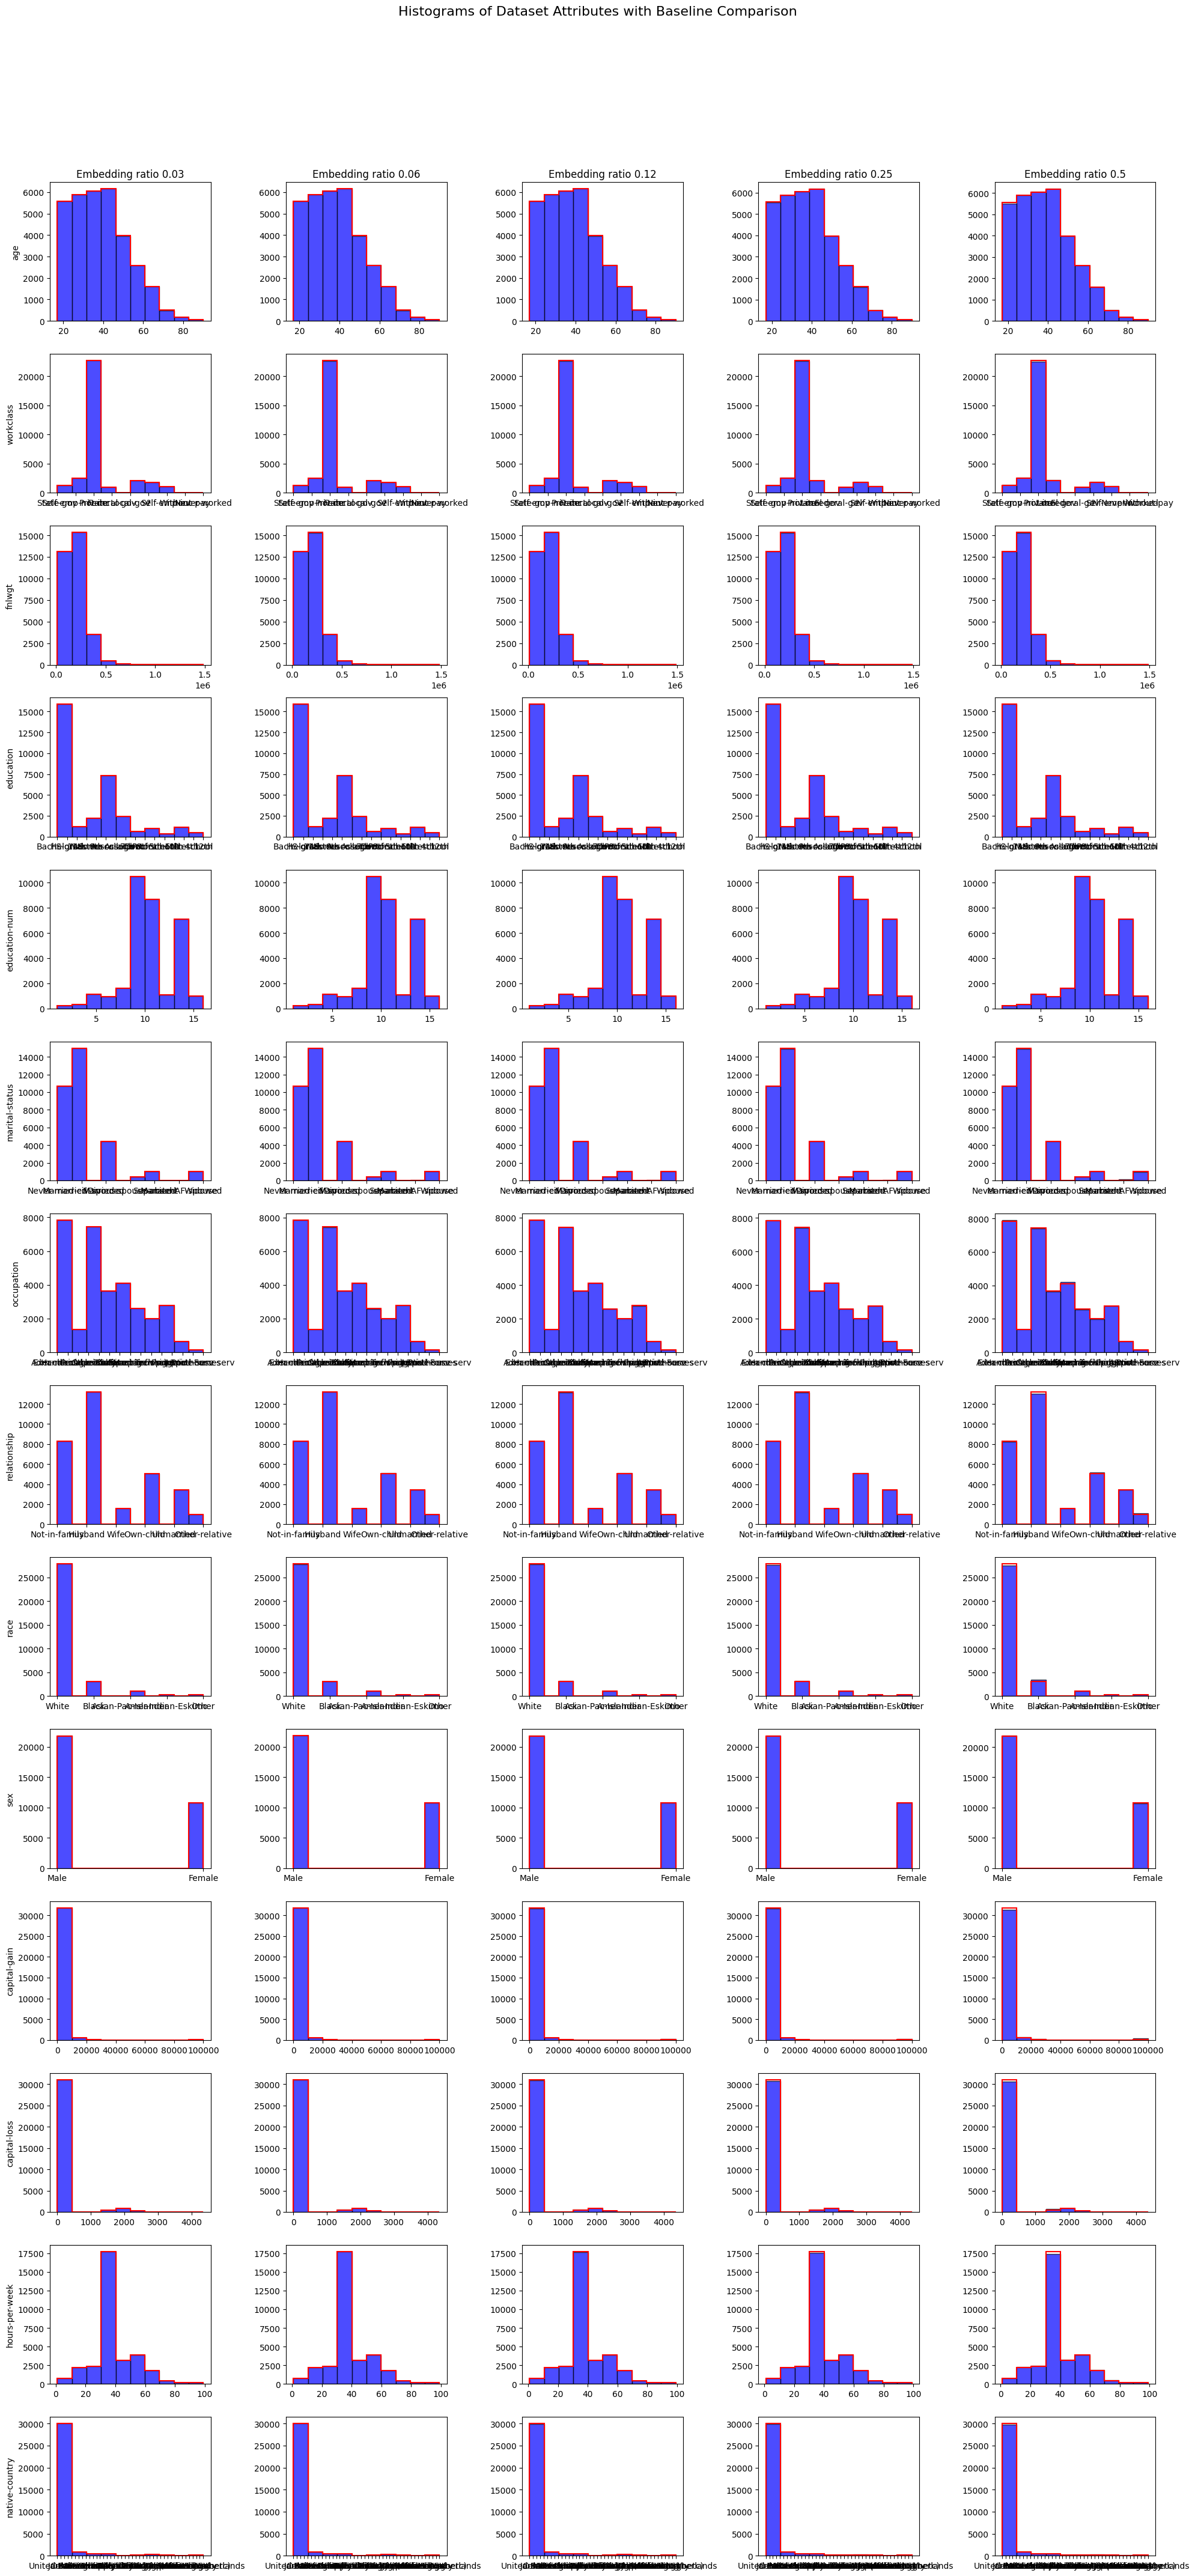

In [65]:
#data_fp_name = f'adult-fp/adult_gamma{gamma}_k{k}_fingerprint_length64_n_recipients20_sk100_id0_codetardos.csv'
# pd.read_csv(f'adult-fp/adult_gamma2_k300_fingerprint_length128_n_recipients20_sk100_id0_codehash.csv')
datasets = [pd.read_csv(f'adult-fp/adult_gamma{gamma}_k300_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv').drop(['Id', 'income'], axis=1) for gamma in [32, 16, 8, 4, 2]]
baseline = pd.read_csv('../../datasets/adult_train_id.csv').drop(['Id', 'income'], axis=1)

plot_histogram_grid(datasets, baseline, columns=5, bins=10)

### 2. Bivariate (pairwise correlations)

In [66]:
# insert correlation matrices

# x-axis: gamma (embedding ratio)
# y-axis: k (neighbourhood size)
# fix: n_recipients (20), sk (100), fp_length (64), recipient_id (0)

# todo: update 

In [72]:
# datasets: [original + 5 gammas] * 2 neighbourhood sizes
datasets = []
gammas = [0, 32, 16, 8, 4, 2]
neighs = [300, 450]
for k in neighs:
    original = pd.read_csv('../../datasets/adult_train_id.csv').drop(['Id', 'income'], axis=1)
    datasets.append(original)
    for gamma in gammas[1:]:
        fp = pd.read_csv(f'adult-fp/adult_gamma{gamma}_k{k}_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv').drop(['Id', 'income'], axis=1)
        datasets.append(fp)

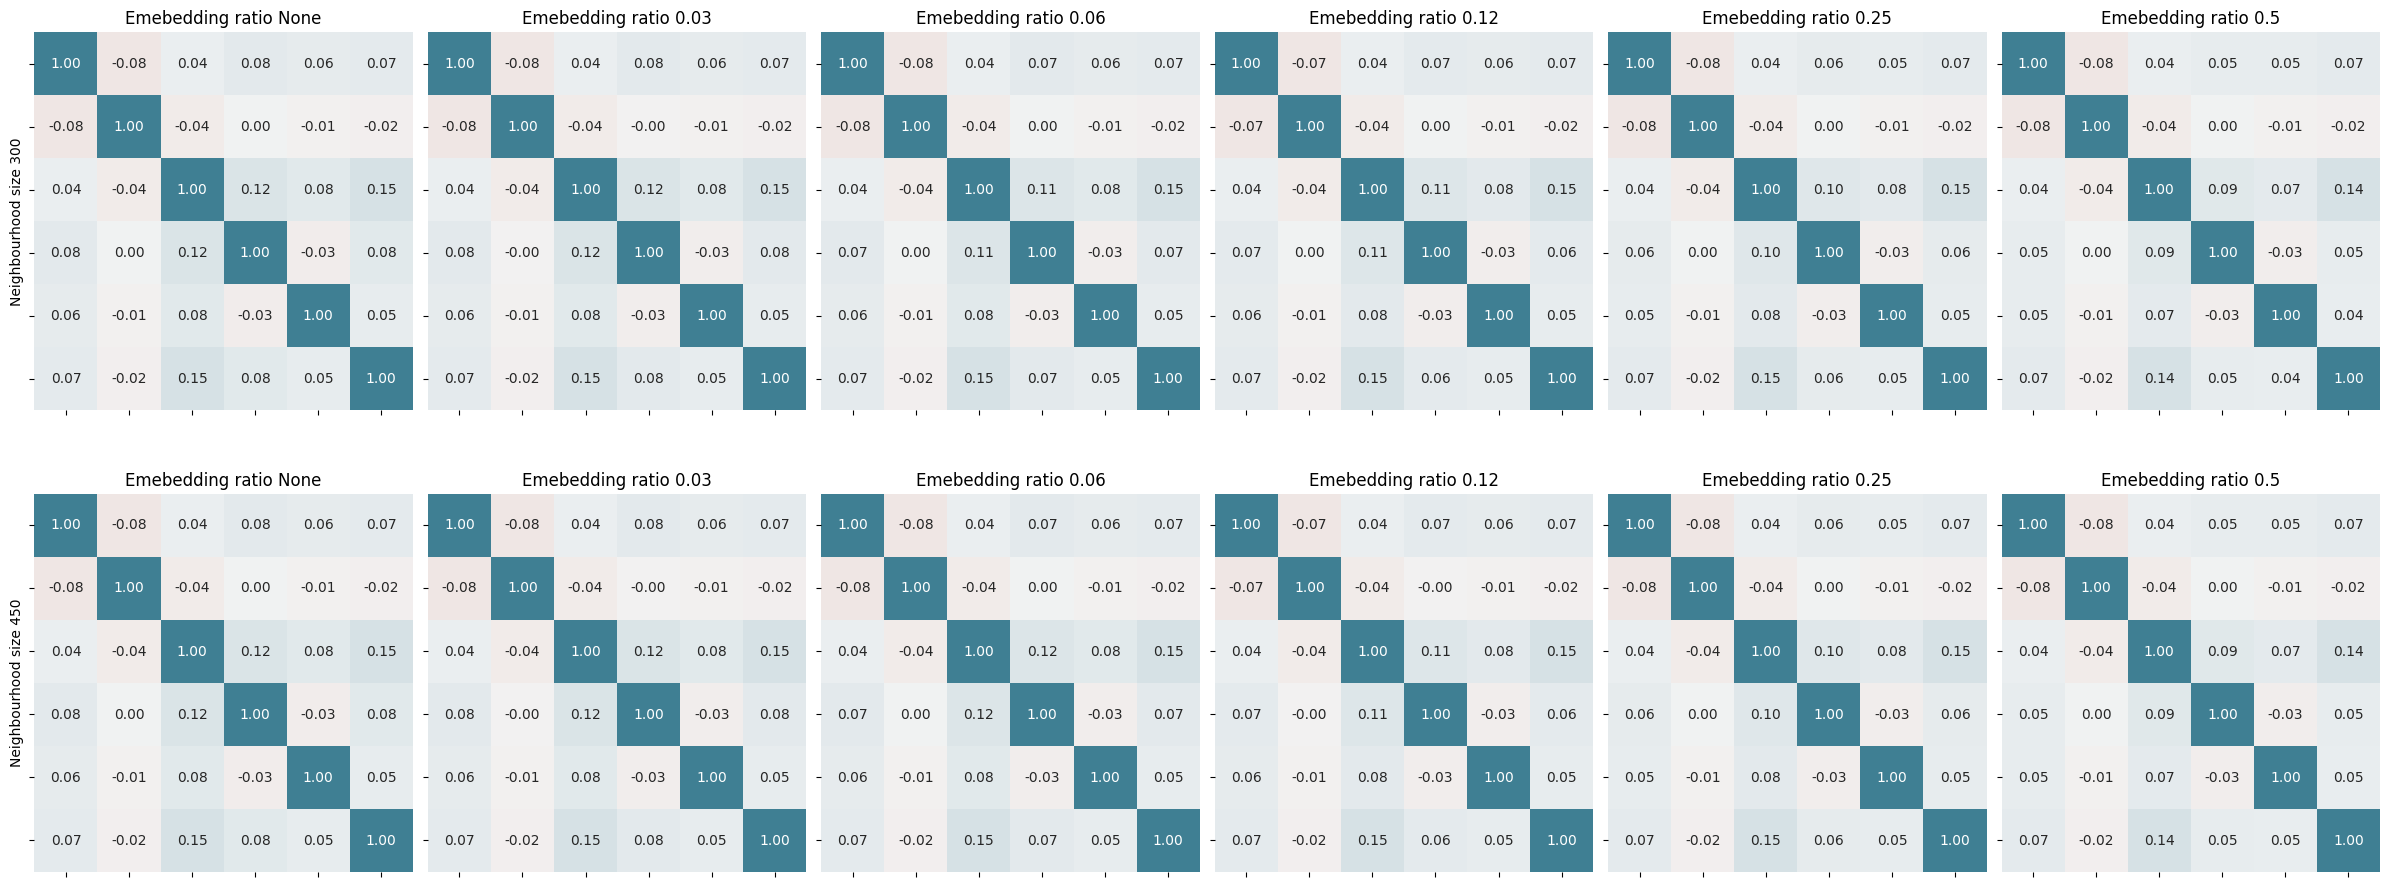

In [81]:
# datasets: (original + 5 fingerprinted) *2 diff neighbourhood sizes
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(24, 10))

# Plotting each correlation matrix in a grid
for i, ax in enumerate(axes.flat):
    sns.heatmap(datasets[i].corr(numeric_only=True), ax=ax, cbar=False, square=True, 
                cmap=sns.diverging_palette(20, 220, as_cmap=True), vmin=-1, vmax=1,  # colors
                annot=True, fmt=".2f") # annotations
    ax.set_title(f"Emebedding ratio {None if gammas[i%len(gammas)]==0 else round(1.0/(gammas[i%len(gammas)]), 2)}")
    #ax.axis('off')  # Optional: turn off axes for a cleaner look
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    if i%len(gammas)==0:
        ax.set_ylabel(f'Neighbourhood size {neighs[int(i/len(gammas))]}')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

None of the numeric attributes are correlated, but we can see that the values stay very similar to the original.

Let's take a look at pairwise histograms.

In [129]:
# randomly fp data
fp_data_rand = pd.read_csv('../../NCorrFP/fp_datasets/random/adult/adult_fp_5_random.csv')
fp_data_ncorr_100 = pd.read_csv(f'adult-fp/adult_gamma5_k100_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv')
fp_data_ncorr_300 = pd.read_csv(f'adult-fp/adult_gamma5_k300_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv')
fp_data_ncorr_450 = pd.read_csv(f'adult-fp/adult_gamma5_k450_fingerprint_length128_n_recipients20_sk100_id0_codetardos.csv')

Text(0.5, 1.0, 'NN scheme (k=100)')

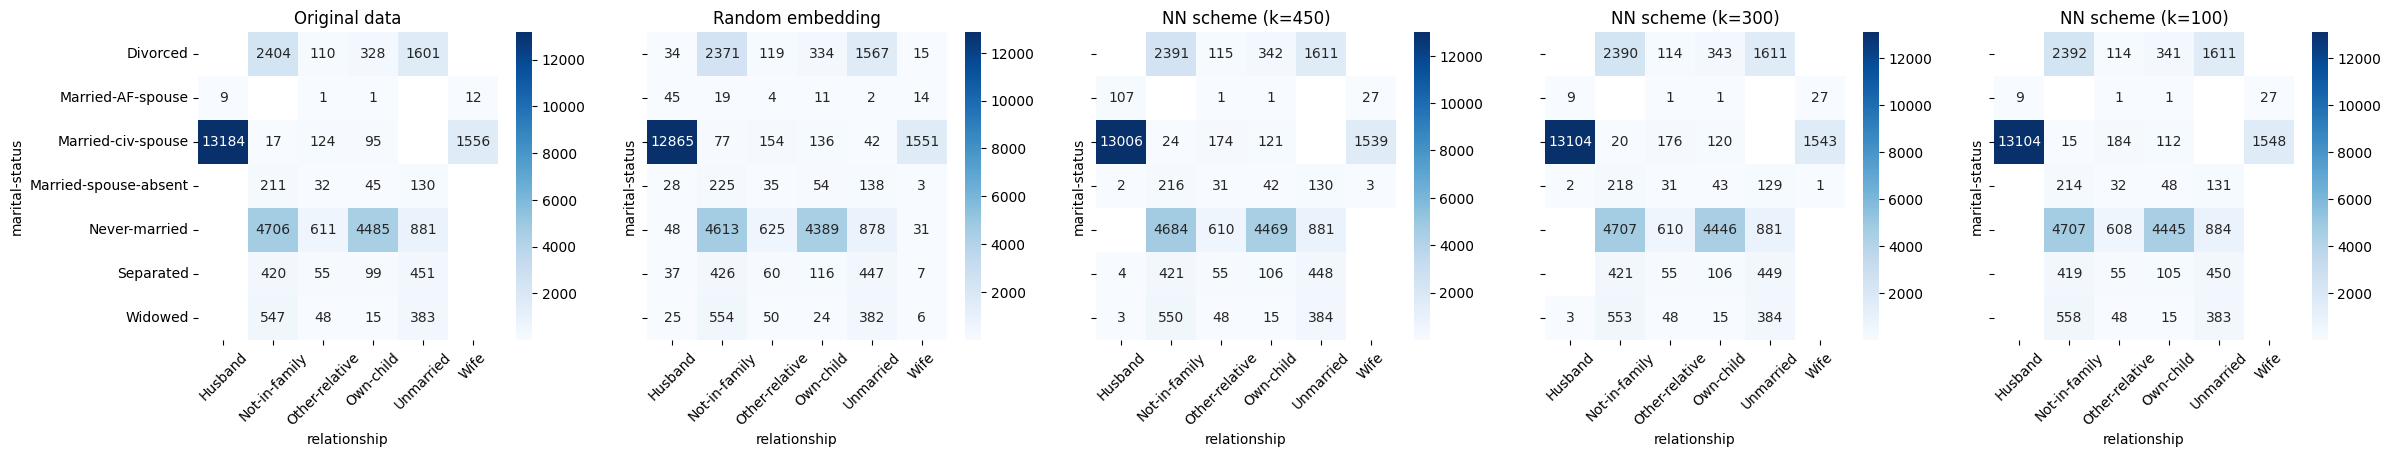

In [134]:
# pairwise histograms
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., relationship and marital status
fig, axs = plt.subplots(1, 5, figsize=(28,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# marital-status vs relationship
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in baseline.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('relationship')
axs[0].set_ylabel('marital-status')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_rand.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('relationship')
axs[1].set_ylabel('marital-status')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_title('Random embedding')

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('relationship')
axs[2].set_ylabel('marital-status')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
axs[2].set_title('NN scheme (k=450)')

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('relationship')
#axs[2].set_ylabel('marital-status')
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)
axs[3].set_title('NN scheme (k=300)')


# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('relationship')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4])
axs[4].set_xlabel('relationship')
axs[4].set_ylabel('marital-status')
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45)
axs[4].set_title('NN scheme (k=100)')

Text(0.5, 1.0, 'NN scheme (k=100)')

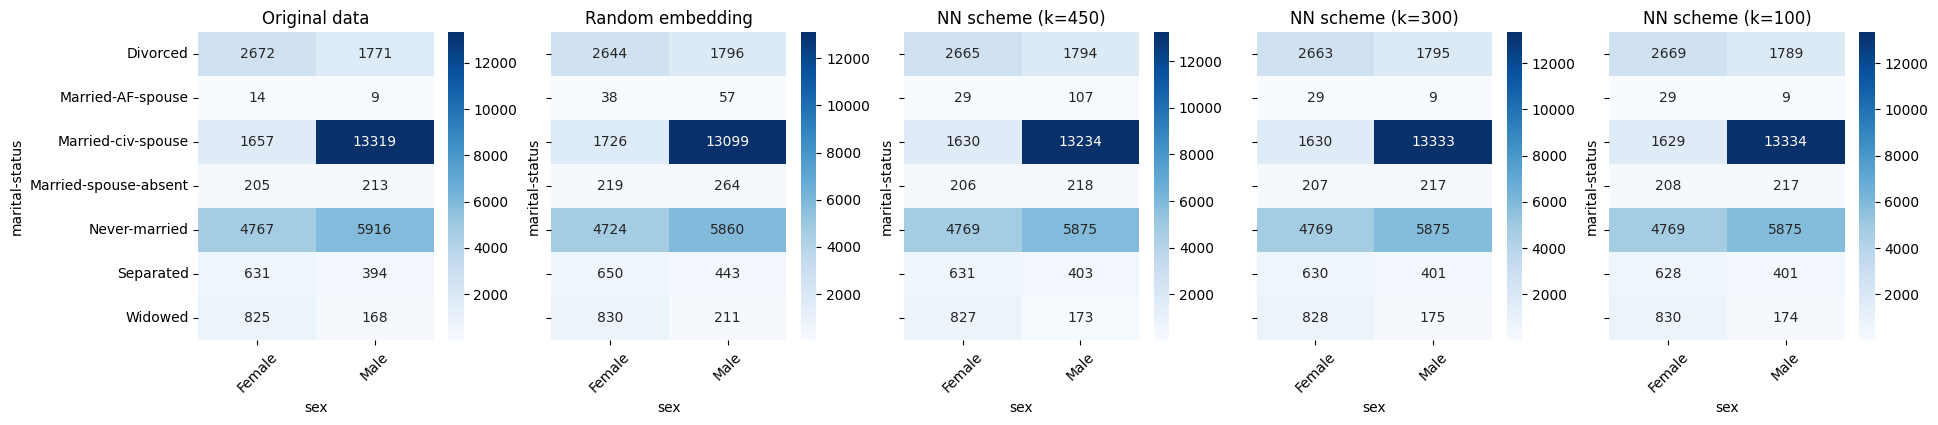

In [149]:
# pairwise histograms
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., sex and marital status
fig, axs = plt.subplots(1, 5, figsize=(22,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# marital-status vs sex
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in baseline.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('sex')
axs[0].set_ylabel('marital-status')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_rand.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('sex')
axs[1].set_ylabel('marital-status')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
axs[1].set_title('Random embedding')

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('sex')
axs[2].set_ylabel('marital-status')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
axs[2].set_title('NN scheme (k=450)')

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('sex')
#axs[2].set_ylabel('marital-status')
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)
axs[3].set_title('NN scheme (k=300)')


# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('sex')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4])
axs[4].set_xlabel('sex')
axs[4].set_ylabel('marital-status')
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45)
axs[4].set_title('NN scheme (k=100)')

Text(0.5, 1.0, 'NN scheme (k=100)')

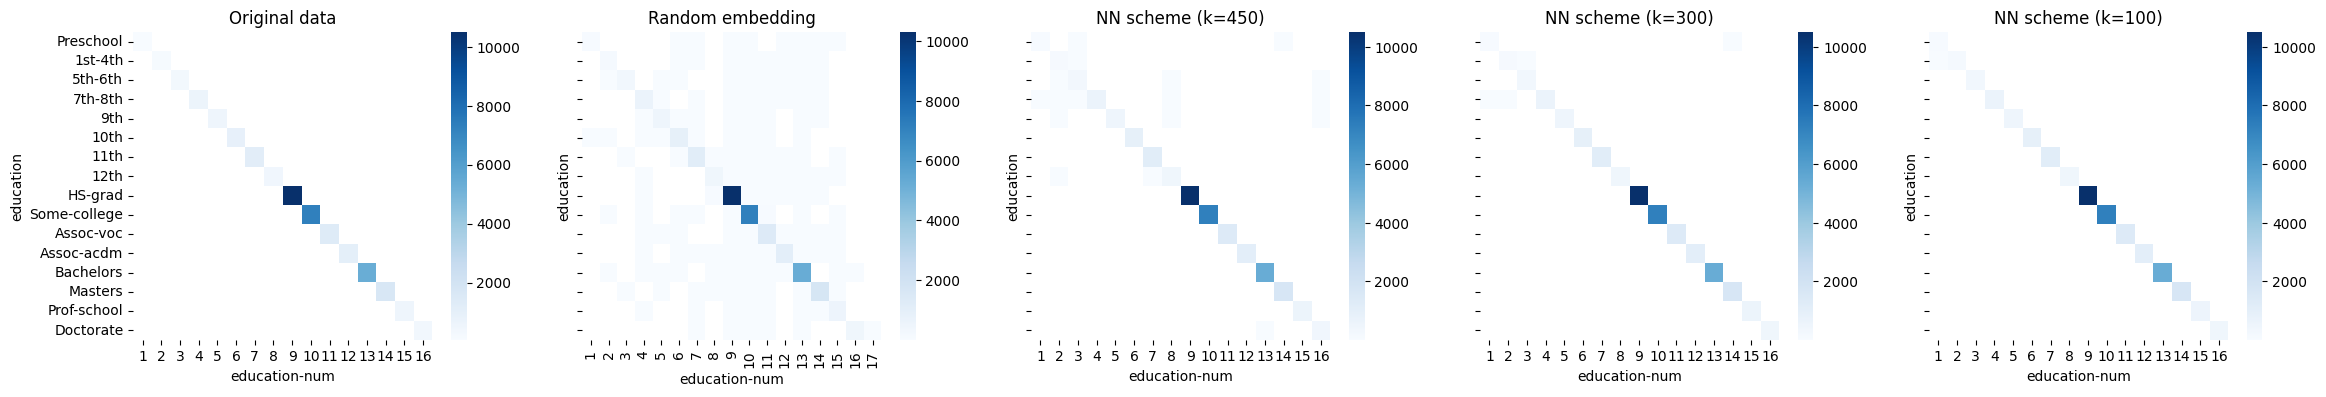

In [140]:
# pairwise histograms
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., relationship and marital status
fig, axs = plt.subplots(1, 5, figsize=(28, 4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')
y_axis_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 
                'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']


############
# ORIGINAL #
############
# education vs education-num
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in baseline.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[0])
axs[0].set_xlabel('education-num')
axs[0].set_ylabel('education')
axs[0].set_xticklabels(axs[0].get_xticklabels())
axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_rand.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[1])
axs[1].set_xlabel('education-num')
axs[1].set_ylabel('education')
axs[1].set_xticklabels(axs[1].get_xticklabels())
axs[1].set_title('Random embedding')

# NCorr 450
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_ncorr_450.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[2])
axs[2].set_xlabel('education-num')
axs[2].set_ylabel('education')
axs[2].set_xticklabels(axs[2].get_xticklabels())
axs[2].set_title('NN scheme (k=450)')

# NCorr k=300
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_ncorr_300.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[3])
axs[3].set_xlabel('education-num')
#axs[2].set_ylabel('education')
axs[3].set_xticklabels(axs[3].get_xticklabels())
axs[3].set_title('NN scheme (k=300)')


# NCorr 100
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in fp_data_ncorr_100.groupby('education-num')
})
df_2dhist = df_2dhist.reindex(y_axis_order)
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=False, ax=axs[4])
axs[4].set_xlabel('education-num')
axs[4].set_ylabel('education')
axs[4].set_xticklabels(axs[4].get_xticklabels())
axs[4].set_title('NN scheme (k=100)')

In [82]:
# insert correlation change with different embedding ratios

# x-axis: gamma (embedding ratio)
# y-axis: relative delta correlation
# colors: attribute pairs 
# fix: n_recipients (20), fp_length (128), recipient_id (0), k (300), code (tardos)

In [83]:
# fix: k (300), n_recipients (20), recipient_id (0), fp_length (64) 
results_fidelity_bivar = results_fidelity_bivar[results_fidelity_bivar["k"]==300]
results_fidelity_bivar = results_fidelity_bivar[results_fidelity_bivar["n_recipients"]==20]
results_fidelity_bivar = results_fidelity_bivar[results_fidelity_bivar["fingerprint_length"]==128]
results_fidelity_bivar = results_fidelity_bivar[results_fidelity_bivar['id']==0]
results_fidelity_bivar = results_fidelity_bivar[results_fidelity_bivar['code']=='tardos']

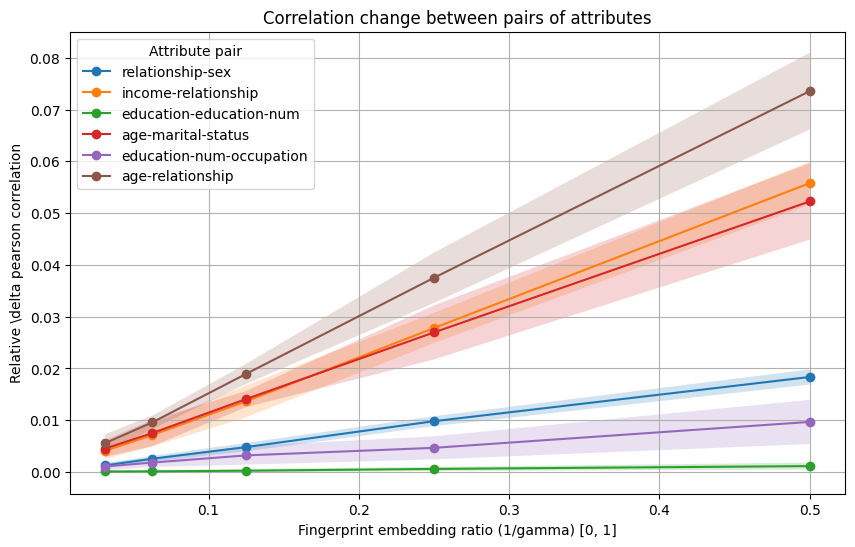

In [84]:
# todo: show the correlated attrs
# todo: add a baseline
plot_delta_corr(results_fidelity_bivar)

### Fidelity: summary

In [37]:
# more dataset similarity statistics
# inspiration from synthetic data
# 1. hellinger distance - The Hellinger Distance measures the similarity between two probability distributions. It is based on the Bhattacharyya coefficient and is often used to quantify the difference between discrete or continuous distributions. Hellinger Distance ranges from 0 to 1, where 0 indicates identical distributions, and 1 indicates completely disjoint distributions.
# 2. pairwise correlation difference (PCD) - Pairwise Correlation Difference measures the absolute difference in correlation coefficients between corresponding feature pairs across two datasets. This metric helps capture structural similarity by looking at how attributes relate to one another in each dataset.
# 3. Propensity score -  quantify the likelihood of a sample belonging to one dataset rather than the other, based on their features. This approach is commonly used in causal inference to assess the similarity of two groups by estimating the probability of group membership
# 4. Log-cluster metric - The Log-Cluster Metric measures similarity by clustering data points within each dataset and then comparing the distributions of clusters. The idea is to capture the structure and density of the data in a non-linear manner.
# 5. Kolmogorov-Smirnov (KS) Statistic for Each Feature - he KS statistic measures the maximum difference between the cumulative distribution functions (CDFs) of two continuous distributions. This test can be applied to each feature independently to assess distributional differences.
# 6. Earth Mover’s Distance (EMD) - EMD quantifies the distance between two distributions by measuring the “cost” of transforming one distribution into another. It’s especially useful for comparing distributions of continuous features.
# 7. Covariance Matrix Distance: By calculating and comparing covariance matrices between two datasets, you can gauge differences in variance and feature relationships. A common method is using the Frobenius norm to quantify the distance between covariance matrices.
# 8. Kullback-Leibler (KL) Divergence: KL divergence measures the “distance” from one probability distribution to another. You can compute KL divergence between corresponding features or feature interactions to capture distributional shifts.

# some of these metrics are 
# (i) particularly useful for continuous features, 
# (ii) useful for measuring the distribution diffs, 
# (iii) measuring the relation to the target attribute

In [38]:
# x-axis: embedding factor 
# y-axis: measure (rel delta mean, rel delta std, hellinger distance, kl divergence, emd, ks, p-value)
# colors: attribute
# fix: k (300), n_recipients (20), id (0), fp_length (64) 
# metrics = ['rel_delta_mean', 'rel_delta_std', 'hellinger_distance', 'kl_divergence', 'emd', 'ks']

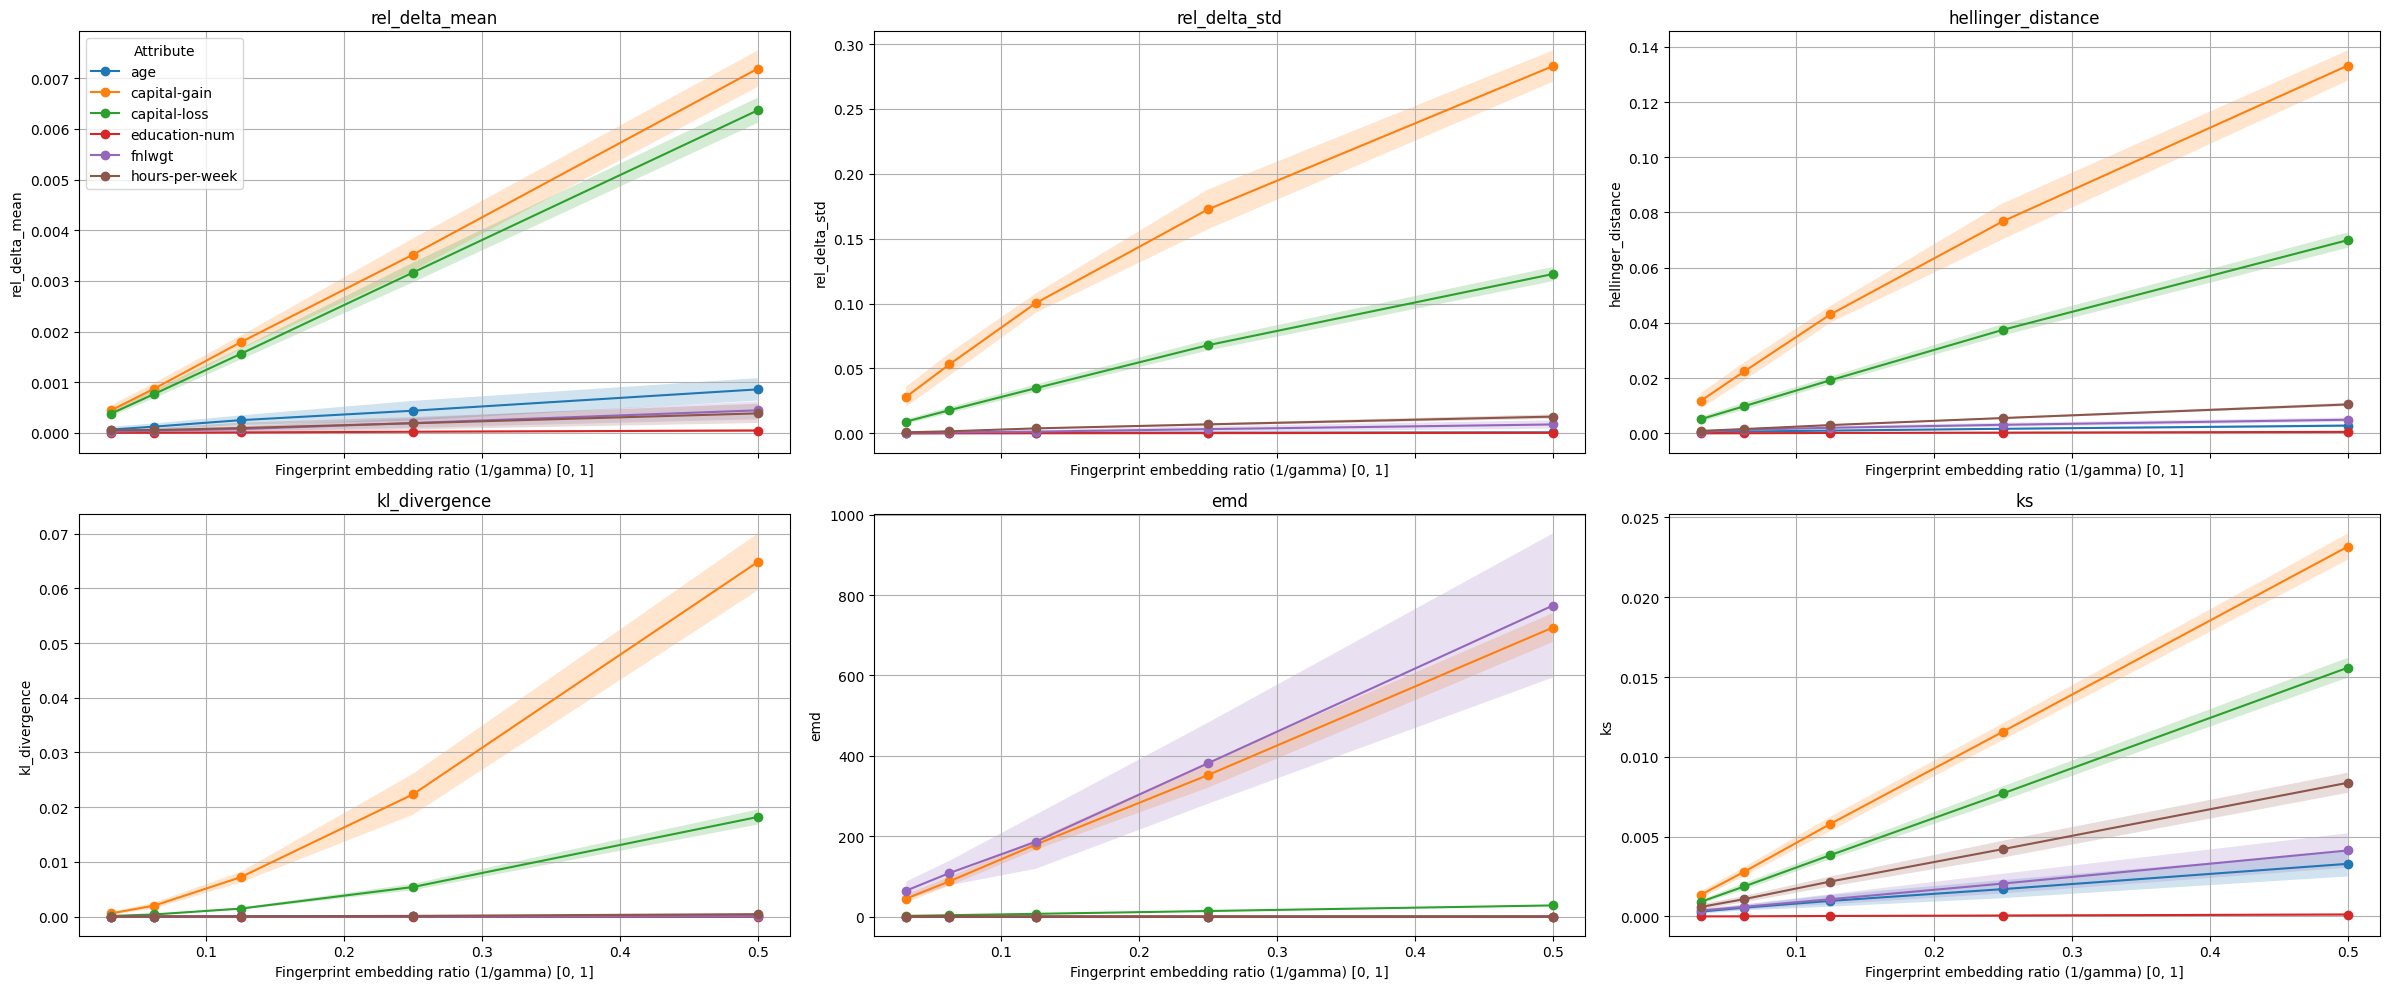

In [150]:
plot_fidelity(results_fidelity_num)

It might make more sense to show fidelity in tables -- todo in the paper.

## 3. Robustness

Robustness is measured by the resilience to the data modifications (attacks)
1. Independent attack: Robustness against flipping and subsetting attack
2. Independent attack: Background knowledge (maybe the correlation-knowing)
3. Collaboration attacks: Collusion on disagreeing values 
4. Collaboration attacks: Collusion with additional modifications

- Robustness stability: same attack, different fingerprinted datasets
- Robustness: same dataset, more randomised attacks

### 3.1 Collusions
Collusion attack is a vunerability of the fingerprinting methods because by cooprating, the recipients might obrtain data copies that do not carry traceable information anymore. 
There are a few things that affect robustness against the collusion such as the length of the fingerprint, the bit-wise difference of the fingerprints and the number of distributed datasets (the total number of recipients).

#### How do we resolve the collusions (accusation mechanism):
- We need a threshold that decides that the fingerpint does not come from a single source, say 95%, i.e. if less than 95% of bits are matching to a single recipient, we assume the collusion.
- Define Suspicion Scores: Assign a suspicion score to each user based on how much their code matches the detected fingerprint. The score is calculated by comparing each bit in the detected fingerprint to each user’s original code. If a bit in the detected fingerprint matches a bit in the user’s code, the user’s score increases.
- Weight the Matches Based on Probability: For each bit in the detected fingerprint, calculate the probability that this bit would have been contributed by a given user in the collusion. Use a scoring function where each matched bit contributes to a user's suspicion score, weighted by its probability.
- Use Log-Score Aggregation: log function is applied to the probability of each bit, which allows the suspicion scores to grow faster for users whose fingerprints align more closely with the detected fingerprint. For example, if the probability of user i contributing a particular bit is p_i, the log-suspicion score for user i based on bit b could be updated by adding log(p_i) or substracting log(1-p_i) if it doesn't.
- Set a Threshold for Detection - Calculate a threshold for the suspicion score, which may be based on the mean suspicion score plus a certain number of standard deviations. Users whose suspicion scores exceed this threshold are identified as potential colluders.

#### Collusion detection measures:
- **Hit rate (true positives)**: the number of correctly identified colluders relative to the total number of accusations. Ideally, this rate is 1.0 when all accused recipients are indeed the colluders.
- **False accusation rate (false attribution, false positive)**: the number of innocent recipients accused relative to total accusations (1 - hit rate). This measure is ideally 0 when there are no innocent recipients accused.
- **Recall** - the number of colluders accused relative to the total number of colluding partners. Recall is ideally 1.0, when all colluders are identified.

#### Colluders' strategies:
The colluders might take a number of paths in the way they attack. 
- hiding - the colluders want to confuse the detection algorithm by lowering the confidences of their fingerprints extraction
- framing - the colluders want to frame an innocent recipient 

These are the actions according to which we model the collusion attack:
- collusion by averaging: combine multiple datasets by taking the average/median of the disagreeing values
- collusion by substitution: combine multiple datasets by substituting disagreeing values with new ones
- collusion by substitution and random modification: collusion by substitution + flip random values where everyone agrees

In [40]:
collusion_results = pd.read_csv('robustness-collusion_adult.csv')

In [41]:
# Calculate the mean and std of hit_abs, false_accusation_rate, and recall
collusion_stats = collusion_results.groupby(['strategy', 'n_colluders', 'fingerprint_length', 'n_recipients', 'threshold'])[['hit_rate', 'false_accusation_rate', 'recall', 'total_accusations']].agg(['mean', 'std']).reset_index()

In [42]:
collusion_stats

strategy n_colluders fingerprint_length n_recipients threshold  \
                                                                        
0           avg           2                 64           20         1   
1           avg           3                 64           20         1   
2           avg           5                 64           20         1   
3           avg          10                 64           20         1   
4        random           2                 64           20         1   
5        random           3                 64           20         1   
6        random           5                 64           20         1   
7        random          10                 64           20         1   
8   random_flip           2                 64           20         1   
9   random_flip           3                 64           20         1   
10  random_flip           5                 64           20         1   
11  random_flip          10                 64           20         1   

    hit_rate           false_accusation_rate              recall            \
        mean       std                  mean       std      mean       std   
0   0.850000  0.199536              0.150000  0.199536  0.950000  0.158114   
1   0.851667  0.162817              0.148333  0.162817  0.933333  0.140546   
2   0.930000  0.113529              0.070000  0.113529  0.700000  0.105409   
3   0.925000  0.120761              0.075000  0.120761  0.300000  0.066667   
4   0.900000  0.161015              0.100000  0.161015  1.000000  0.000000   
5   0.705000  0.295757              0.295000  0.295757  0.733333  0.262937   
6   0.483333  0.221248              0.516667  0.221248  0.340000  0.134990   
7   0.500000  0.254588              0.500000  0.254588  0.170000  0.094868   
8   0.850000  0.199536              0.150000  0.199536  1.000000  0.000000   
9   0.661667  0.258085              0.338333  0.258085  0.700000  0.245955   
10  0.300000  0.201077              0.700000  0.201077  0.180000  0.113529   
11  0.541667  0.322150              0.458333  0.322150  0.180000  0.091894   

   total_accusations            
                mean       std  
0                2.3  0.483046  
1                3.4  0.843274  
2                3.8  0.632456  
3                3.3  0.823273  
4                2.3  0.483046  
5                3.5  1.269296  
6                3.7  1.059350  
7                3.5  0.707107  
8                2.5  0.707107  
9                3.4  0.966092  
10               2.9  0.875595  
11               3.4  1.577621

In [48]:
collusion_stats.to_csv("collusion-stats.csv", index=False)

#### Interpretation:
- strategy: collusion strategy (avg: averaging the differences, random: substituting the diffs, random_flip: substitute diffs and additionally modify values)
- n_colluders: number of colluding datasets
- fingerprint_length
- n_recipients: total number of distributed datasets
- threshold: decision parameters for accusation score cut-off 
- hit rate, false_accusation_rate and recall (mean, std): *see above*
- total_accusations: total number of detected colludes


The experiment show that collusion by substitution + additional flipping is the best strategy by the attackers, followed by the substitution alone, and averaging is the worse. A hypothesis is that the more successful techniques also decrease the data utility more.

Furthermore, hit rate and recall show good values for up to 3 colluders, but fail for larger collaborations. 